In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os 
from glob import glob
from sympy import nsimplify
import sympy

In [2]:
results_directory = r'results/results_for_the_paper/'

In [3]:
dataset_names = pd.read_csv('datasets', names=['Index', 'Name', 'Formula'])
dataset_names_dict = {dataset_names['Name'][i]: dataset_names['Index'][i] for i in range(len(dataset_names))}

In [4]:
# Biggest problem: we count scalar multiplication as 2 complexity, while SRBench counts it as 1
# Small problem (which is maybe just a problem of our method: we count in a_1*\sqrt(a_2*x) 2 scalar multiplication, while it could be just 1. 

function_names = ['sin', 'cos', 'sqrt', 'exp']
variable_names = [f'x{i}' for i in range(10)]
operations = ['+', '-', '/', '*']
# formula = '(x0*sqrt(((((x2*x2)+(x1*x1)))+(x3*x3))))+sqrt(((((x2*x2)+(x1*x1)))+(x3*x3)))'
formula = '1.0*x0*(x1*cos(1.0*x2 + 18.85) + 1)'

def get_expr(formula, function_names):
    expr = None
    for function_name in function_names:
        index_start = formula.find(function_name)
        if index_start != -1:
            found_end = False
            index_stop = index_start
            while not found_end:
                index_stop = formula.find(')', index_stop+1)
                expr = formula[index_start:index_stop+1]
                if expr.count('(') == expr.count(')'):
                    found_end = True
    return expr

def is_scalar_multiplication(formula, index):
    digits = []
    for i in range(10):
        digits.append(f'{i}')
    # We assume here that there are no more than 10 variables and no potence higher than 9
    return (formula[index-1] in digits) and (formula[index-2] in digits or formula[index-2] == '.')

def count(formula, variable_names, operations):
    complexity = 0
    for variable_name in variable_names:
        complexity += formula.count(variable_name)
    # Before we get to multiplication (*) we have to remove the potences (**)
    complexity += formula.count('**')
    formula = formula.replace('**', '')
    for operation in operations:
        complexity += formula.count(operation)
    complexity += formula.count('^')
    complexity += formula.count('.')
    # Get rid of the complexity 2 for scalar multiplication
    start_index = 0
    remaining_multiplications = True
    while remaining_multiplications:
        index = formula.find('*', start_index)
        if index != -1:
            if is_scalar_multiplication(formula, index):
                complexity -= 1
            start_index = index + 1
        else:
            remaining_multiplications = False
    return complexity

def get_complexity(formula, function_names, variable_names, operations):
    expr = get_expr(formula, function_names)
    if not expr is None:
        formula_red = formula.replace(expr, variable_names[0])
    else:
        formula_red = formula
    complexity = count(formula_red, variable_names, operations)
    if not expr is None:
        complexity += count(expr, variable_names, operations)
    return complexity

## Without noise

### 1-norm

#### Loading

In [53]:
list_results = []
path = os.path.join(results_directory, 'With limits', 'Without noise', 'l1')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230825_105801_philipp_cluster_strogatz; Length: 56
Directory: 20230825_104929_philipp_cluster_feynman; Length: 80
Directory: 20230825_105630_philipp_cluster_feynman; Length: 36
Directory: 20230825_105049_philipp_cluster_feynman; Length: 80
Directory: 20230825_105441_philipp_cluster_feynman; Length: 80
Directory: 20230825_105518_philipp_cluster_feynman; Length: 40
Directory: 20230825_105116_philipp_cluster_feynman; Length: 80
Directory: 20230825_105021_philipp_cluster_feynman; Length: 80


/tmp/ipykernel_11106/3845025340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11106/3845025340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11106/3845025340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

In [54]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.0,True,326.245,20,4,8.858490e-08,1.0,1.0,1.726*x0*sqrt(Abs(0.336*x1**2 + 0.336*x2**2 + ...,154580
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.0,True,296.019,35,4,8.749716e-08,1.0,1.0,1.775*x0*sqrt(Abs(0.317*x1**2 + 0.317*x2**2 + ...,150085
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.0,True,235.196,35,4,8.992241e-08,1.0,1.0,1.624*x0*sqrt(Abs(0.379*x1**2 + 0.379*x2**2 + ...,111611
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.0,True,227.859,20,4,9.156048e-08,1.0,1.0,1.558*x0*sqrt(Abs(0.412*x1**2 + 0.412*x2**2 + ...,113777
121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.0,True,4.594,13,1,7.739357e-08,1.0,1.0,0.159*x0*x1,3802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.0,True,2.317,13,3,1.657425e-07,1.0,1.0,-3.333*x0**3 + 3.333*x0 + 10.0*x1,3446
254,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.0,True,0.983,13,1,3.155608e-08,1.0,1.0,-0.1*x0,1388
254,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.0,True,0.996,13,1,3.155527e-08,1.0,1.0,-0.1*x0,1399


In [55]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [56]:
results.columns

Index(['max_deg_input', 'max_deg_output', 'max_deg_input_denominator',
       'max_deg_output_denominator', 'max_deg_output_polynomials_specific',
       'max_deg_output_polynomials_denominator_specific', 'width',
       'function_names', 'maximal_potence', 'maximal_n_functions', 'maxiter1',
       'maxiter2', 'target_noise', 'feature_noise', 'optimizer',
       'pruning_iterations', 'pruning_cut_off', 'classifier',
       'local_minimizer', 'maxiter_per_dim_local_minimizer',
       'max_dataset_length', 'lambda_1', 'repetitions', 'parallel',
       'n_processes', 'lambda_1_cut', 'lambda_1_piecewise', 'device',
       'accuracy', 'time_limit', 'evaluations_limit', 'iterative_finetuning',
       'max_n_active_parameters', 'dataset', 'target_formula',
       'estimated_formula', 'relative_l2_train', 'relative_l2_val',
       'relative_l2_test', 'r_squared_val', 'r_squared_test', 'success',
       'training_time', 'n_active_coefficients',
       'n_active_coefficients_reduced', 'relative_

In [57]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [58]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(344, 498, 496)

In [59]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_11106/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11106/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11106/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

#### Symbolic recovery rate

In [60]:
accurracy_solution = results['r_squared_test_final'] > 0.999
symbolic_recovery_rate_approx = (results['r_squared_test_final'] > 0.9999999999) & (results['n_active_coefficients_final'] < 10)
np.mean(accurracy_solution), np.mean(results['r_squared_test_final'] > 0.9999999999), np.mean(symbolic_recovery_rate_approx)

(0.924812030075188, 0.5413533834586466, 0.38345864661654133)

In [61]:
results.head(10)[['n_active_coefficients_reduced', 'r_squared_test_final', 'n_active_coefficients_final', 'estimated_formula_final']]

,n_active_coefficients_reduced,r_squared_test_final,n_active_coefficients_final,estimated_formula_final
Index,,,,
120,4,1.0,4,1.726*x0*sqrt(Abs(0.336*x1**2 + 0.336*x2**2 + ...
120,4,1.0,4,1.775*x0*sqrt(Abs(0.317*x1**2 + 0.317*x2**2 + ...
120,4,1.0,4,1.624*x0*sqrt(Abs(0.379*x1**2 + 0.379*x2**2 + ...
120,4,1.0,4,1.558*x0*sqrt(Abs(0.412*x1**2 + 0.412*x2**2 + ...
121,1,1.0,13,0.159*x0*x1
121,1,1.0,1,0.159*x0*x1
121,1,1.0,13,0.159*x0*x1
121,1,1.0,1,0.159*x0*x1
122,2,1.0,2,12.566*x0*x1**2*x2/x3


In [62]:
candidates = (results['r_squared_test_final'] > 0.9999999999).values #results['r_squared_test_final'] > 0.9999999999

for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i}; target expression: {results[candidates]["target_formula"].iloc[i]};' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0; target expression: mom*sqrt(Bx**2+By**2+Bz**2);estimated expression: 1.00048465055692*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 1; target expression: mom*sqrt(Bx**2+By**2+Bz**2);estimated expression: 0.999373866478407*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 2; target expression: mom*sqrt(Bx**2+By**2+Bz**2);estimated expression: 0.999782728396525*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 3; target expression: mom*sqrt(Bx**2+By**2+Bz**2);estimated expression: 1.00003698331612*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 4; target expression: n*(h/(2*pi));estimated expression: 0.159*x0*x1
i: 5; target expression: n*(h/(2*pi));estimated expression: 0.159*x0*x1
i: 6; target expression: n*(h/(2*pi));estimated expression: 0.159*x0*x1
i: 7; target expression: n*(h/(2*pi));estimated expression: 0.159*x0*x1
i: 8; target expression: 2*E_n*d**2*k/(h/(2*pi));estimated expression: 12.566*x0*x1**2*x2/x3
i: 9; target expression: 2*E_n*d**2*k/(h/(2*pi));estimated expression: 12.566*x0*x1**2*x2/x3
i: 10; targe

In [63]:
sympy.simplify(results[candidates]['estimated_formula_final'].iloc[27],rational=False)

-1.0*x0*x1*x2/x3

In [64]:
failed_candidates = [49, 115, 243, 272]

In [65]:
double_check_candidates = [115, 243]

In [66]:
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if candidates[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1

/tmp/ipykernel_11106/1961766837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['symbolic_recovery_final'].iloc[i] = False


In [67]:
sum(candidates) / len(candidates), results['symbolic_recovery_final'].mean()

(0.5413533834586466, 0.5338345864661654)

In [68]:
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999

#### Complexity

In [69]:
results['complexity_final'] = results['estimated_formula_final'].apply(get_complexity, args=(function_names, variable_names, operations))

#### Saving 

In [71]:
results.groupby(['maxiter1']).mean()['training_time']

maxiter1
100    2316.504105
Name: training_time, dtype: float64

In [70]:
results.groupby(['maxiter_per_dim_local_minimizer', 'max_dataset_length']).mean()[['r_squared_test_final', 
                                                                                   'symbolic_recovery_final',
                                                                                  'n_active_coefficients_final',
                                                                                  'accuracy_solution_final', 'complexity_final']]

r_squared_test_final  \
maxiter_per_dim_local_minimizer max_dataset_length                         
50                              500                             0.997420   
                                1000                            0.999139   
100                             500                             0.999375   
                                1000                            0.998495   

                                                    symbolic_recovery_final  \
maxiter_per_dim_local_minimizer max_dataset_length                            
50                              500                                0.496241   
                                1000                               0.541353   
100                             500                                0.556391   
                                1000                               0.541353   

                                                    n_active_coefficients_final  \
maxiter_per_dim_local_minimizer max_dataset_length                                
50                              500                                   28.759398   
                                1000                                  29.909774   
100                             500                                   32.015038   
                                1000                                  38.654135   

                                                    accuracy_solution_final  \
maxiter_per_dim_local_minimizer max_dataset_length                            
50                              500                                0.924812   
                                1000                               0.924812   
100                             500                                0.932331   
                                1000                               0.917293   

                                                    complexity_final  
maxiter_per_dim_local_minimizer max_dataset_length                    
50                              500                       125.639098  
                                1000                      131.473684  
100                             500                       112.218045  
                                1000                      131.150376

In [77]:
results.to_csv(os.path.join(path, 'results_combined_analyzed.csv'))

In [78]:
results_best_hp = results[(results['maxiter_per_dim_local_minimizer'] == 100) & (results['max_dataset_length'] == 500)]

In [79]:
results_best_hp['simplified_formulas'] = 0
for i in range(len(results_best_hp)):
    print(f'Iteration {i}')
    print(f'Simplifying the formula {results_best_hp["estimated_formula_final"].iloc[i]}')
    if len(results_best_hp['estimated_formula_final'].iloc[i]) < 200:
        results_best_hp['simplified_formulas'].iloc[i] = sympy.simplify(results_best_hp['estimated_formula_final'].iloc[i])
        print(f'Simplified to {results_best_hp["simplified_formulas"].iloc[i]}')
    else:
        results_best_hp['simplified_formulas'].iloc[i] = results_best_hp['estimated_formula_final'].iloc[i]
        print('Formula too long, did not simplify')

/tmp/ipykernel_11516/1120108386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_best_hp['simplified_formulas'] = 0
/tmp/ipykernel_11516/1120108386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_best_hp['simplified_formulas'].iloc[i] = sympy.simplify(results_best_hp['estimated_formula_final'].iloc[i])
/tmp/ipykernel_11516/1120108386.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Iteration 0
Simplifying the formula 1.775*x0*sqrt(Abs(0.317*x1**2 + 0.317*x2**2 + 0.317*x3**2))
Simplified to 0.999373866478407*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
Iteration 1
Simplifying the formula 0.159*x0*x1
Simplified to 0.159*x0*x1
Iteration 2
Simplifying the formula 12.566*x0*x1**2*x2/x3
Simplified to 12.566*x0*x1**2*x2/x3
Iteration 3
Simplifying the formula 0.002*x0**2*x1**2 - 0.002*x0**2*x1*exp((-0.002*x0 - 1.175*x1 + 0.052*x2 - 0.012*x4 - 0.028)/(0.085*x1*x2 + 0.04*x1*x3 + 0.049*x1*x4 - 0.214*x1 - 0.048*x2**2 + 0.113*x2*x3 + 0.12*x2*x4 + 0.051*x2 - 0.072*x3**2 - 0.947*x3*x4 + 0.02*x3 - 0.081*x4**2 - 0.046)) + 0.006*x0**2*x1 + 0.012*x0**2*x3*x4 - 0.022*x0**2*x3 - 0.021*x0**2*x4 + 0.028*x0**2 - 0.01*x0*x1**2*x2 - 0.023*x0*x1**2*exp((-0.002*x0 - 1.175*x1 + 0.052*x2 - 0.012*x4 - 0.028)/(0.085*x1*x2 + 0.04*x1*x3 + 0.049*x1*x4 - 0.214*x1 - 0.048*x2**2 + 0.113*x2*x3 + 0.12*x2*x4 + 0.051*x2 - 0.072*x3**2 - 0.947*x3*x4 + 0.02*x3 - 0.081*x4**2 - 0.046)) - 0.081*x0*x1*x2**2 + 0.007*x0*x

In [80]:
# results_best_hp['simplified_formulas'] = results['estimated_formula_final'].apply(sympy.simplify)
results_best_hp['complexity_final'] = results_best_hp['estimated_formula_final'].apply(get_complexity, args=(function_names, variable_names, operations))

/tmp/ipykernel_11516/4038307207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_best_hp['complexity_final'] = results_best_hp['estimated_formula_final'].apply(get_complexity, args=(function_names, variable_names, operations))


In [83]:
results_best_hp[['r_squared_test_final', 'symbolic_recovery_final', 'n_active_coefficients_final', 'accuracy_solution_final', 'complexity_final']].mean()

r_squared_test_final             0.999375
symbolic_recovery_final          0.556391
n_active_coefficients_final     32.015038
accuracy_solution_final          0.932331
complexity_final               112.218045
dtype: float64

In [84]:
results_best_hp.to_csv(os.path.join(path, 'results_best_hp.csv'))

### 1-norm and 200 iterations

#### Loading

In [72]:
list_results = []
path = os.path.join(results_directory, 'With limits', 'Without noise', '200 iteration')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230911_074127_philipp_cluster_strogatz; Length: 14
Directory: 20230911_081246_philipp_cluster_feynman; Length: 18
Directory: 20230911_074312_philipp_cluster_feynman; Length: 18
Directory: 20230911_074625_philipp_cluster_feynman; Length: 18
Directory: 20230908_104028_philipp_cluster_feynman; Length: 49
Directory: 20230911_081306_philipp_cluster_feynman; Length: 16


/tmp/ipykernel_11106/3515712891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11106/3515712891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11106/3515712891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

In [73]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,520.259,35,4,8.855872e-08,1.000000,1.000000,1.77*x0*sqrt(Abs(0.319*x1**2 + 0.319*x2**2 + 0...,279727
121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,7.153,13,1,7.738023e-08,1.000000,1.000000,0.159*x0*x1,7285
122,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,49.514,71,2,1.019632e-07,1.000000,1.000000,12.566*x0*x1**2*x2/x3,29959
123,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999993,False,4951.768,48,23,1.980689e-03,0.999996,0.999996,1.15*x0*exp((-0.022*x1**2 - 2.079*x1*x2 - 0.02...,805196
124,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,571.586,28,9,6.169093e-08,1.000000,1.000000,2.0*x0*cos(1.0*x1*x2 - 3.142) + 2.0*x0,279285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,15.833,13,5,8.886906e-08,1.000000,1.000000,(0.053*x0*x1**2 - 0.707*x0*x1 + 0.053*x1**2)/(...,20010
251,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999144,False,1763.358,33,33,2.926452e-02,0.999144,0.999966,(0.054*x0**3*x1 - 0.0145375637464223*x0**3*exp...,997940
252,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999933,False,1771.126,29,29,8.186236e-03,0.999933,0.999976,0.003*x0**3*x1 + 0.163663038413915*x0**3*exp(-...,998523


In [74]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [75]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [76]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(91, 133, 105)

In [77]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_11106/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11106/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
/tmp/ipykernel_11106/2960987597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

#### Determine the symbolic solution rate

In [78]:
candidates = results['r_squared_test_final'] > 0.999999999

for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i} \ntarget expression: {results[candidates]["target_formula"].iloc[i]} \n' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0 
target expression: mom*sqrt(Bx**2+By**2+Bz**2) 
estimated expression: 0.99969750424816*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 1 
target expression: n*(h/(2*pi)) 
estimated expression: 0.159*x0*x1
i: 2 
target expression: 2*E_n*d**2*k/(h/(2*pi)) 
estimated expression: 12.566*x0*x1**2*x2/x3
i: 3 
target expression: 2*U*(1-cos(k*d)) 
estimated expression: 2.0*x0*(cos(1.0*x1*x2 - 3.142) + 1)
i: 4 
target expression: (h/(2*pi))**2/(2*E_n*d**2) 
estimated expression: 0.013*x0**2/(x1*x2**2)
i: 5 
target expression: 2*pi*alpha/(n*d) 
estimated expression: 6.283*x0/(x1*x2)
i: 6 
target expression: beta*(1+alpha*cos(theta)) 
estimated expression: 1.0*x0*(x1*cos(1.0*x2) + 1)
i: 7 
target expression: -rho_c_0*q*A_vec/m 
estimated expression: -1.0*x0*x1*x2/x3
i: 8 
target expression: 2*mom*B/(h/(2*pi)) 
estimated expression: 12.566*x0*x1/x2
i: 9 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*cos(12.566*x0*x1/x2 - 12.566)
i: 10 
target expression: sigma_den/epsil

In [79]:
sum(candidates) / len(candidates)

0.5639097744360902

In [80]:
sympy.simplify(results[candidates]['estimated_formula_final'].iloc[46],rational=False)

1.0*x0/x1

In [81]:
failed_candidates = []

In [82]:
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if list(candidates)[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1

In [83]:
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999

#### Complexity

In [84]:
results['complexity_final'] = results['estimated_formula_final'].apply(get_complexity, args=(function_names, variable_names, operations))

#### Saving 

In [85]:
results.groupby(['maxiter1']).mean()[['r_squared_test_final', 'symbolic_recovery_final', 'n_active_coefficients_final', 'accuracy_solution_final', 'complexity_final']]

,r_squared_test_final,symbolic_recovery_final,n_active_coefficients_final,accuracy_solution_final,complexity_final
maxiter1,,,,,
200,0.999109,0.56391,36.864662,0.947368,147.338346


In [86]:
results.to_csv(os.path.join(path, 'results_combined_analyzed.csv'))

### 1-norm piecewise

#### Loading

In [100]:
list_results = []
path = os.path.join(results_directory, 'With limits', 'Without noise', 'l1piecewise')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230828_103610_philipp_cluster_feynman; Length: 15
Directory: 20230828_103247_philipp_cluster_feynman; Length: 30
Directory: 20230828_103701_philipp_cluster_feynman; Length: 14
Directory: 20230828_103438_philipp_cluster_feynman; Length: 30
Directory: 20230828_103823_philipp_cluster_strogatz; Length: 14
Directory: 20230828_103205_philipp_cluster_feynman; Length: 30


/tmp/ipykernel_11516/2866396692.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11516/2866396692.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11516/2866396692.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

In [101]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,221.596,20,4,8.862978e-08,1.000000,1.000000,1.729*x0*sqrt(Abs(0.335*x1**2 + 0.335*x2**2 + ...,98544
121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,4.046,13,1,7.737932e-08,1.000000,1.000000,0.159*x0*x1,2681
122,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,2244.588,112,75,1.717799e-04,1.000000,1.000000,-200.0*(-0.002*x0**2 - 0.066*x0*x1**2*x2 - 0.0...,471993
123,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999820,False,4818.921,111,111,1.342159e-02,0.999820,0.999854,(-0.002*x0**3 + 0.005*x0**2*x1 + 0.007*x0**2*x...,609911
124,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,False,4821.965,28,4,4.698953e-08,1.000000,1.000000,-2.0*x0*cos(1.0*x1*x2) + 2.0*x0,989304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,10.400,13,5,8.610996e-08,1.000000,1.000000,(-0.053*x0*x1**2 + 0.707*x0*x1 - 0.053*x1**2)/...,6932
251,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999402,False,3216.165,41,41,2.444563e-02,0.999402,0.999964,(0.049*x0**3*x1 - 0.308*x0**3*exp((0.474*x0 + ...,999265
252,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999548,False,3233.699,44,44,2.126214e-02,0.999548,0.999973,(0.049*x0**3*x1 - 0.013*x0**3*sqrt(Abs((-0.21*...,998840


In [102]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [103]:
results.columns

Index(['max_deg_input', 'max_deg_output', 'max_deg_input_denominator',
       'max_deg_output_denominator', 'max_deg_output_polynomials_specific',
       'max_deg_output_polynomials_denominator_specific', 'width',
       'function_names', 'maximal_potence', 'maximal_n_functions', 'maxiter1',
       'maxiter2', 'target_noise', 'feature_noise', 'optimizer',
       'pruning_iterations', 'pruning_cut_off', 'classifier',
       'local_minimizer', 'maxiter_per_dim_local_minimizer',
       'max_dataset_length', 'lambda_1', 'repetitions', 'parallel',
       'n_processes', 'lambda_1_cut', 'lambda_1_piecewise', 'device',
       'accuracy', 'time_limit', 'evaluations_limit', 'iterative_finetuning',
       'max_n_active_parameters', 'dataset', 'target_formula',
       'estimated_formula', 'relative_l2_train', 'relative_l2_val',
       'relative_l2_test', 'r_squared_val', 'r_squared_test', 'success',
       'training_time', 'n_active_coefficients',
       'n_active_coefficients_reduced', 'relative_

In [104]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [105]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(89, 122, 99)

In [106]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_11516/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11516/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
/tmp/ipykernel_11516/2960987597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

#### Determine the symbolic solution rate

In [107]:
accurracy_solution = results['r_squared_test_final'] > 0.999
symbolic_recovery_rate_approx = (results['r_squared_test_final'] > 0.99999999) & (results['n_active_coefficients_final'] < 10)
np.mean(accurracy_solution), np.mean(results['r_squared_test_final'] > 0.9999999), np.mean(symbolic_recovery_rate_approx)

(0.9172932330827067, 0.5263157894736842, 0.3383458646616541)

In [108]:
results.head(10)[['n_active_coefficients_reduced', 'r_squared_test_final', 'n_active_coefficients_final', 'estimated_formula_final']]

,n_active_coefficients_reduced,r_squared_test_final,n_active_coefficients_final,estimated_formula_final
Index,,,,
120,4,1.000000,4,1.729*x0*sqrt(Abs(0.335*x1**2 + 0.335*x2**2 + ...
121,1,1.000000,1,0.159*x0*x1
122,75,1.000000,112,-200.0*(0.001*x0**2*x1 - 0.003*x0**2 - 0.065*x...
123,111,0.999820,111,(-0.002*x0**3 + 0.005*x0**2*x1 + 0.007*x0**2*x...
124,4,1.000000,4,-2.0*x0*cos(1.0*x1*x2) + 2.0*x0
125,10,0.999999,26,(0.059*x0*cos((-0.024*x0 + 0.006*x1 - 1.565*x2...
126,2,1.000000,2,6.283*x0/(x1*x2)
127,5,1.000000,5,1.0*x0*x1*cos(1.0*x2 + 18.85) + 1.0*x0
128,34,0.987196,34,(0.390256970886548*x0**2*exp(0.312*x0 + 1.001*...


In [109]:
candidates = results['r_squared_test_final'] > 0.999999999

for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i}; target expression: {results[candidates]["target_formula"].iloc[i]};' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0; target expression: mom*sqrt(Bx**2+By**2+Bz**2);estimated expression: 1.00073110024622*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 1; target expression: n*(h/(2*pi));estimated expression: 0.159*x0*x1
i: 2; target expression: 2*U*(1-cos(k*d));estimated expression: 2.0*x0*(1 - cos(1.0*x1*x2))
i: 3; target expression: 2*pi*alpha/(n*d);estimated expression: 6.283*x0/(x1*x2)
i: 4; target expression: beta*(1+alpha*cos(theta));estimated expression: 1.0*x0*(x1*cos(1.0*x2 + 18.85) + 1)
i: 5; target expression: -rho_c_0*q*A_vec/m;estimated expression: 8.987*x0*x1*cos(0.001*x2 + 4.712)/(0.086*x0*cos(0.001*x2 + 4.712) + 0.074*x1*cos(0.001*x2 + 4.712) - 0.001*x2**2 - 0.001*x2*x3 + 0.933*x2*cos(0.001*x2 + 4.712) + 0.34*x3*cos(0.001*x2 + 4.712) - 0.013*x3 + 0.004*cos(0.001*x2 + 4.712))
i: 6; target expression: 2*mom*B/(h/(2*pi));estimated expression: 12.566*x0*x1/x2
i: 7; target expression: sin(E_n*t/(h/(2*pi)))**2;estimated expression: 0.5*cos(12.566*x0*x1/x2 - 15.708) + 0.5
i: 8; target expression:

In [110]:
sympy.simplify(results[candidates]['estimated_formula_final'].iloc[46],rational=False)

0.315793888477912*x0*x2*sqrt(Abs(x1**2))/(-0.421*x1 + 0.316*x3 + 0.421223509552826*sqrt(Abs(x1**2)))

In [111]:
failed_candidates = [49, 115, 243, 272]

In [112]:
candidates.mean()

0.45864661654135336

In [113]:
failed_candidates = [5, 30, 35, 46, ...] # Stopped since it was obviously worse than the normal 1-norm...

In [114]:
6/ 38, 1 / (2* np.pi), 66  / 412, 106 / 666, 99 / 612

(0.15789473684210525,
 0.15915494309189535,
 0.16019417475728157,
 0.15915915915915915,
 0.16176470588235295)

### BFGS

#### Loading

In [37]:
list_results = []
path = os.path.join(results_directory, 'With limits', 'Without noise', 'BFGS')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230912_104607_philipp_cluster_feynman; Length: 21
Directory: 20230912_115212_philipp_cluster_feynman; Length: 15
Directory: 20230912_141508_philipp_cluster_strogatz; Length: 14
Directory: 20230912_104747_philipp_cluster_feynman; Length: 21
Directory: 20230912_105444_philipp_cluster_feynman; Length: 21
Directory: 20230912_110107_philipp_cluster_feynman; Length: 20
Directory: 20230912_105223_philipp_cluster_feynman; Length: 21


/tmp/ipykernel_11106/3384463480.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11106/3384463480.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11106/3384463480.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

In [38]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,51.276,35,4,9.055646e-08,1.000000,1.000000,1.571*x0*sqrt(Abs(0.405*x1**2 + 0.405*x2**2 + ...,19833
121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,0.441,13,1,7.739361e-08,1.000000,1.000000,0.159*x0*x1,322
122,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,702.880,112,2,1.021431e-07,1.000000,1.000000,12.566*x0*x1**2*x2/x3,100971
123,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999986,False,4838.118,131,90,2.217773e-03,0.999995,0.999998,(-0.001*x0**3 + 0.001*x0**2*x1 + 0.001*x0**2*x...,349589
124,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,True,98.341,50,5,4.661908e-08,1.000000,1.000000,-2.0*x0*cos(1.0*x1*x2 - 6.283) + 2.0*x0,28874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,1.359,13,5,8.418607e-08,1.000000,1.000000,(-0.053*x0*x1**2 + 0.707*x0*x1 - 0.053*x1**2)/...,1194
251,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999990,False,4800.819,58,58,3.137731e-03,0.999990,0.999998,(-0.021*x0**3*x1 - 0.019*x0**3*cos(0.386*x0 - ...,825705
252,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,4078.720,27,9,3.161943e-08,1.000000,1.000000,0.053*cos(2.0*x1)*cos(1.0*x0 - 2.085) + 0.405*...,753738


In [39]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [ ]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [41]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(95, 133, 94)

In [42]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_11106/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11106/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
/tmp/ipykernel_11106/2960987597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

#### Determine the symbolic solution rate

In [43]:
candidates = results['r_squared_test_final'] > 0.999999999

for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i} \ntarget expression: {results[candidates]["target_formula"].iloc[i]} \n' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0 
target expression: mom*sqrt(Bx**2+By**2+Bz**2) 
estimated expression: 0.999778277919659*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 1 
target expression: n*(h/(2*pi)) 
estimated expression: 0.159*x0*x1
i: 2 
target expression: 2*E_n*d**2*k/(h/(2*pi)) 
estimated expression: 12.566*x0*x1**2*x2/x3
i: 3 
target expression: 2*U*(1-cos(k*d)) 
estimated expression: 2.0*x0*(1 - cos(1.0*x1*x2 - 6.283))
i: 4 
target expression: (h/(2*pi))**2/(2*E_n*d**2) 
estimated expression: 0.013*x0**2/(x1*x2**2)
i: 5 
target expression: 2*pi*alpha/(n*d) 
estimated expression: 6.283*x0/(x1*x2)
i: 6 
target expression: beta*(1+alpha*cos(theta)) 
estimated expression: 1.0*x0*(x1*cos(1.0*x2) + 1)
i: 7 
target expression: -rho_c_0*q*A_vec/m 
estimated expression: -1.0*x0*x1*x2/x3
i: 8 
target expression: 2*mom*B/(h/(2*pi)) 
estimated expression: 12.566*x0*x1/x2
i: 9 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: (0.13*x0**2*cos(12.566*x0*x1/x2 - 3.142) + 0.13*x0**2 + 0.007*x0*x1*cos(12.566*x

In [44]:
sum(candidates) / len(candidates)

0.5789473684210527

In [45]:
sympy.simplify(results[candidates]['estimated_formula_final'].iloc[9],rational=False)

(0.13*x0**2*cos(12.566*x0*x1/x2 - 3.142) + 0.13*x0**2 + 0.007*x0*x1*cos(12.566*x0*x1/x2 - 3.142) + 0.007*x0*x1 + 0.108*x0*x2*cos(12.566*x0*x1/x2 - 3.142) + 0.108*x0*x2 + 0.02*x0*cos(12.566*x0*x1/x2 - 3.142) + 0.02*x0 + 0.023*x1**2*cos(12.566*x0*x1/x2 - 3.142) + 0.023*x1**2 + 0.152*x1*x2*cos(12.566*x0*x1/x2 - 3.142) + 0.152*x1*x2 + 0.012*x1*cos(12.566*x0*x1/x2 - 3.142) + 0.012*x1 + 0.443*x2**2*cos(12.566*x0*x1/x2 - 3.142) + 0.443*x2**2 + 0.014*x2*cos(12.566*x0*x1/x2 - 3.142) + 0.014*x2 + 0.029*cos(12.566*x0*x1/x2 - 3.142) + 0.029)/(0.259*x0**2 + 0.015*x0*x1 + 0.215*x0*x2 + 0.04*x0 + 0.045*x1**2 + 0.303*x1*x2 + 0.024*x1 + 0.886*x2**2 + 0.029*x2 + 0.058)

In [46]:
failed_candidates = [9, 13, 19, 28, 68]

In [47]:
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if list(candidates)[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1

/tmp/ipykernel_11106/2919028803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['symbolic_recovery_final'].iloc[i] = False


In [48]:
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999

#### Complexity

In [49]:
results['complexity_final'] = results['estimated_formula_final'].apply(get_complexity, args=(function_names, variable_names, operations))

#### Saving 

In [52]:
results.groupby(['maxiter1']).mean()['training_time']

maxiter1
200    2258.674376
Name: training_time, dtype: float64

In [50]:
results.groupby(['maxiter1']).mean()[['r_squared_test_final', 'symbolic_recovery_final', 'n_active_coefficients_final', 'accuracy_solution_final', 'complexity_final']]

,r_squared_test_final,symbolic_recovery_final,n_active_coefficients_final,accuracy_solution_final,complexity_final
maxiter1,,,,,
200,0.997013,0.541353,61.285714,0.977444,176.12782


In [51]:
results.to_csv(os.path.join(path, 'results_combined_analyzed.csv'))

## With noise

### L1 piecewise

#### Loading

In [115]:
list_results = []
path = os.path.join(results_directory, 'With limits', 'With noise', 'l1piecewise')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230828_104139_philipp_cluster_feynman; Length: 30
Directory: 20230829_123221_philipp_cluster_feynman; Length: 11
Directory: 20230829_123209_philipp_cluster_feynman; Length: 13
Directory: 20230829_123156_philipp_cluster_feynman; Length: 17
Directory: 20230829_123315_philipp_cluster_strogatz; Length: 14
Directory: 20230829_123142_philipp_cluster_feynman; Length: 18
Directory: 20230828_104057_philipp_cluster_feynman; Length: 30
Directory: 20230829_154937_philipp_cluster_strogatz; Length: 14


/tmp/ipykernel_11516/2521437408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11516/2521437408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11516/2521437408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

In [116]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999384,False,4812.782,31,6,0.024756,0.999387,0.999394,2.391*x0*sqrt(Abs(0.175*x1**2 + 0.175*x2**2 + ...,828886
121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999588,False,3400.842,18,4,0.020286,0.999588,0.999590,0.159*x0*x1,995180
122,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999806,True,4825.213,56,17,0.013071,0.999829,0.999833,1.0*(0.017*x0**3*sqrt(Abs(-0.009*x0*x1 + 0.006...,829702
123,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999667,False,4838.199,119,61,0.014409,0.999792,0.999772,-0.073*x0*x1**2 - 0.116*x0*x1*x2 + 0.015*x0*x1...,605492
124,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999737,False,4760.410,28,5,0.015745,0.999752,0.999757,2.0*x0*cos(1.0*x1*x2 + 3.142) + 2.0*x0,984876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999520,False,2960.508,38,38,0.021916,0.999520,0.999748,(0.011*x0**3*x1 + 0.054*x0**3*sqrt(Abs(0.11*x0...,998250
253,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999922,True,2551.633,19,19,0.008828,0.999922,0.999392,-3.25*x0**3 - 0.15*x0**2*x1 - 0.33*x0**2*sqrt(...,999307
253,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999913,True,0.951,13,5,0.009194,0.999915,0.999880,-3.34*x0**3 + 0.011*x0**2*x1 - 0.006*x0*x1**2 ...,683


In [117]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [118]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [119]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(91, 143, 98)

In [120]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_11516/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11516/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11516/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

#### Determine the symbolic solution rate

In [121]:
accurracy_solution = results['r_squared_test_final'] > 0.999
symbolic_recovery_rate_approx = (results['r_squared_test_final'] > 0.99999999) & (results['n_active_coefficients_final'] < 10)
np.mean(accurracy_solution), np.mean(results['r_squared_test_final'] > 0.9999999), np.mean(symbolic_recovery_rate_approx)

(0.8027210884353742, 0.0, 0.0)

In [122]:
candidates = []
for i in results['estimated_formula_final'].index:
    candidates.append(len(str(results.loc[i, 'estimated_formula_final'])) < 200)
sum(candidates) / len(candidates)

0.4965986394557823

In [123]:
for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i}; target expression: {results[candidates]["target_formula"].iloc[i]};' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0; target expression: mom*sqrt(Bx**2+By**2+Bz**2);estimated expression: 1.00022706172149*x0*sqrt(Abs(x1**2 + x2**2 + x3**2))
i: 1; target expression: n*(h/(2*pi));estimated expression: 0.159*x0*x1
i: 2; target expression: 2*U*(1-cos(k*d));estimated expression: 2.0*x0*(cos(1.0*x1*x2 + 3.142) + 1)
i: 3; target expression: 2*pi*alpha/(n*d);estimated expression: (6.28124999999999*x0 - 0.00107758620689655)/(x1*x2)
i: 4; target expression: -rho_c_0*q*A_vec/m;estimated expression: -1.0*x0*x1*x2/x3
i: 5; target expression: (h/(2*pi))*omega/(exp((h/(2*pi))*omega/(kb*T))-1);estimated expression: (0.013*x0*x1**2 - 0.058*x0*x1*x2 - 0.056*x0*x1*x3 + 0.085*x0*x2*x3 - 0.101*x1*x2*x3 + 0.698*x2**2*x3 + 0.687*x2*x3**2 - 0.148*x2*x3)/(0.088*x0 - 0.1*x1 + 0.697*x2 + 0.688*x3 - 0.156)
i: 6; target expression: 2*mom*B/(h/(2*pi));estimated expression: (12.555*x0*x1 + 0.053*x1 - 0.124*sqrt(Abs((0.056*x0 + 0.024*x1**2 - 0.03*x2 - 0.121)/(0.15*x0 + 0.97*x1 - 0.192*x2))))/x2
i: 7; target expression: sin(E_n*

In [124]:
index = 71
print(f'target expression: {results[candidates]["target_formula"].iloc[index]}')
print(f'estimated expression: {sympy.simplify(results[candidates]["estimated_formula_final"].iloc[index],rational=False)}')

target expression:  -(1)/(10) * x
estimated expression: 0.002*x0**2*x1**2 + 0.001*x0**2*x1 - 0.001*x0**2 - 0.014*x0*x1**3 + 0.008*x0*x1**2 + 0.003*x0*x1 - 0.1*x0 + 0.02*x1**3 - 0.019*x1**2 + 0.001


In [125]:
failed_candidates = [5, 6, 10, 11, 18, 21, 25, 27, 37, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                    62, 64, 65, 66, 67, 68, 69, 70, 71]

In [126]:
close_failed_candidates = [64, 70, 71] # not complete

In [127]:
(sum(candidates) - len(failed_candidates)) / len(candidates)

0.25170068027210885

In [128]:
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if candidates[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1

/tmp/ipykernel_11516/1961766837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['symbolic_recovery_final'].iloc[i] = False


In [129]:
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999

In [130]:
results.groupby(['maxiter_per_dim_local_minimizer', 'max_dataset_length']).mean()[['r_squared_test_final', 
                                                                                   'symbolic_recovery_final',
                                                                                  'n_active_coefficients_final',
                                                                                  'accuracy_solution_final']]

,,r_squared_test_final,symbolic_recovery_final,n_active_coefficients_final,accuracy_solution_final
maxiter_per_dim_local_minimizer,max_dataset_length,,,,
100,500,0.849199,0.251701,38.646259,0.802721


In [131]:
results.to_csv(os.path.join(path, 'results_combined_analyzed.csv'))

### 1-norm 

#### Loading

In [132]:
list_results = []
# path = os.path.join(results_directory, 'With limits', 'With noise', 'l1', 'Dataset length 500')
path = os.path.join(results_directory, 'With limits', 'With noise', 'l1', 'Dataset length 1000')
# path = os.path.join(results_directory, 'With limits', 'With noise', 'l1 and finetuning l1')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230831_124115_philipp_cluster_feynman; Length: 13
Directory: 20230831_124155_philipp_cluster_strogatz; Length: 14
Directory: 20230831_124131_philipp_cluster_feynman; Length: 12
Directory: 20230831_123934_philipp_cluster_feynman; Length: 19
Directory: 20230831_123756_philipp_cluster_feynman; Length: 19
Directory: 20230831_124006_philipp_cluster_feynman; Length: 19
Directory: 20230831_124054_philipp_cluster_feynman; Length: 18
Directory: 20230831_123915_philipp_cluster_feynman; Length: 19


/tmp/ipykernel_11516/2214768318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11516/2214768318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_11516/2214768318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['datase

In [133]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999998,False,4849.839,20,4,0.000571,1.000000,0.999392,1.78*x0*sqrt(Abs(0.315*x1**2 + 0.315*x2**2 + 0...,862863
121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,False,2986.122,18,8,0.000035,1.000000,0.999582,0.159*x0*x1,999766
122,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999998,True,26.376,71,23,0.000686,1.000000,0.999834,(0.042*x0**2*x1*x2 - 0.068*x0**2*x1*x3 + 0.014...,16092
123,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999958,False,4827.271,204,55,0.002989,0.999991,0.999799,-0.002*x0**2*x1*x2 - 0.007*x0**2*x1*exp((0.003...,535119
124,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999995,False,3972.248,24,4,0.000608,1.000000,0.999752,-2.001*x0*cos(1.0*x1*x2 + 6.282) + 2.0*x0,998785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999996,True,7.914,13,5,0.001266,0.999998,0.999925,(-0.053*x0*x1**2 + 0.708*x0*x1 - 0.053*x1**2)/...,9732
251,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.999341,False,2102.225,38,38,0.025662,0.999341,0.999933,(-0.091*x0**3*x1 + 0.0217060000480996*x0**3*ex...,998048
252,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,0.998884,True,2099.830,44,44,0.033401,0.998884,0.999848,(0.074*x0**3*x1 - 0.118*x0**3*sqrt(Abs((0.059*...,999458


In [134]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [135]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [136]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(78, 129, 122)

In [137]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_11516/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_11516/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
/tmp/ipykernel_11516/2960987597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

#### Determine the symbolic solution rate

In [138]:
accurracy_solution = results['r_squared_test_final'] > 0.999
symbolic_recovery_rate_approx = (results['r_squared_test_final'] > 0.99999999) & (results['n_active_coefficients_final'] < 10)
np.mean(accurracy_solution), np.mean(results['r_squared_test_final'] > 0.9999999), np.mean(symbolic_recovery_rate_approx)

(0.9022556390977443, 0.18045112781954886, 0.05263157894736842)

In [139]:
candidates = []
for i in results['estimated_formula_final'].index:
    candidates.append(len(str(results.loc[i, 'estimated_formula_final'])) < 200)
sum(candidates) / len(candidates)

0.45112781954887216

In [140]:
for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i}')
    print(f'target expression: {results[candidates]["target_formula"].iloc[i]}')
    print(f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0
target expression: mom*sqrt(Bx**2+By**2+Bz**2)
estimated expression: 1.78*x0*sqrt(Abs(0.315*x1**2 + 0.315*x2**2 + 0.316*x3**2))
i: 1
target expression: n*(h/(2*pi))
estimated expression: 0.159*x0*x1
i: 2
target expression: 2*U*(1-cos(k*d))
estimated expression: x0*(2.0 - 2.001*cos(1.0*x1*x2 + 6.282))
i: 3
target expression: 2*pi*alpha/(n*d)
estimated expression: (6.273*x0 + 0.012*x1 + 0.001*x2)/(x1*x2)
i: 4
target expression: beta*(1+alpha*cos(theta))
estimated expression: 1.0*x0*(x1*cos(1.0*x2) + 1)
i: 5
target expression: 1/(exp((h/(2*pi))*omega/(kb*T))-1)
estimated expression: -0.01*x0/x1 - 0.445 - 0.012*x1/x0 + 6.277*x2*x3/(x0*x1)
i: 6
target expression: sin(E_n*t/(h/(2*pi)))**2
estimated expression: 0.5 - 0.5*cos(12.566*x0*x1/x2 - 6.282)
i: 7
target expression: sigma_den/epsilon*1/(1+chi)
estimated expression: 0.671*x0/(0.001*x0 + 0.671*x1*x2 + 0.67*x1 - 0.003)
i: 8
target expression: n_rho*p_d**2*Ef/(3*kb*T)
estimated expression: 0.333*x0*x1**2*x2/(x3*x4)
i: 9
target express

In [141]:
index = 27
print(f'target expression: {results[candidates]["target_formula"].iloc[index]}')
print(f'estimated expression: {sympy.simplify(results[candidates]["estimated_formula_final"].iloc[index],rational=False)}')

target expression: m_0/sqrt(1-v**2/c**2)
estimated expression: 1.574*x0*sqrt(Abs((0.011*x0*x2 + 0.266*x2**2 - 0.005)/(0.006*x0**2 + 0.067*x0*x1 - 0.015*x0*x2 - 0.169*x0 + 0.614*x1**2 - 0.014*x1*x2 + 0.031*x1 - 0.658*x2**2 - 0.052*x2 + 0.391)))


In [142]:
# failed_candidates = [1, 6, 11, 12, 20, 24, 25, 26, 31, 35, 36, 41, 47, 51, 55, 57, 58, 63] # Dataset length 500
# close_failed_candidates = [1, 20, 25, 26, 41, 51, 63] # Dataset length 500

failed_candidates = [3, 5, 11, 20, 23, 27, 34, 51, 53, 56, 57, 58] # Dataset length 1000
close_failed_candidates = [3, 20, 51, 57, 58] # Dataset length 1000

failed_candidates = [2, 8, 12, 15, 17, ...] # l1 and finetuning l1 # Not complete since there are too few (there are already less candidates than for the previous l1=0.00001
close_failed_candidates = [2, 8] # l1 and finetuning l1

(sum(candidates) - len(failed_candidates)) / len(candidates)

0.40601503759398494

In [143]:
results['symbolic_recovery_final'] = candidates
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if candidates[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999
results.groupby(['maxiter_per_dim_local_minimizer', 'max_dataset_length']).mean()[['r_squared_test_final', 
                                                                                   'symbolic_recovery_final',
                                                                                  'n_active_coefficients_final',
                                                                                  'accuracy_solution_final']]

/tmp/ipykernel_11516/4119513185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['symbolic_recovery_final'].iloc[i] = False


,,r_squared_test_final,symbolic_recovery_final,n_active_coefficients_final,accuracy_solution_final
maxiter_per_dim_local_minimizer,max_dataset_length,,,,
100,1000,0.999048,0.413534,35.699248,0.902256


In [144]:
results.groupby(['maxiter_per_dim_local_minimizer', 'max_dataset_length']).median()[['r_squared_test_final', 
                                                                                   'symbolic_recovery_final',
                                                                                  'n_active_coefficients_final',
                                                                                  'accuracy_solution_final']]

,,r_squared_test_final,symbolic_recovery_final,n_active_coefficients_final,accuracy_solution_final
maxiter_per_dim_local_minimizer,max_dataset_length,,,,
100,1000,0.999995,0.0,23.0,1.0


#### Complexity

In [145]:
results['simplified_formulas'] = 0
for i in range(len(results)):
    print(f'Iteration {i}')
    print(f'Simplifying the formula {results["estimated_formula_final"].iloc[i]}')
    if len(results['estimated_formula_final'].iloc[i]) < 200:
        results['simplified_formulas'].iloc[i] = sympy.simplify(results['estimated_formula_final'].iloc[i])
        print(f'Simplified to {results["simplified_formulas"].iloc[i]}')
    else:
        results['simplified_formulas'].iloc[i] = results['estimated_formula_final'].iloc[i]
        print('Formula too long, did not simplify')

Iteration 0
Simplifying the formula 1.78*x0*sqrt(Abs(0.315*x1**2 + 0.315*x2**2 + 0.316*x3**2))
Simplified to 1.78*x0*sqrt(Abs(0.315*x1**2 + 0.315*x2**2 + 0.316*x3**2))
Iteration 1
Simplifying the formula 0.159*x0*x1
Simplified to 0.159*x0*x1
Iteration 2
Simplifying the formula (0.042*x0**2*x1*x2 - 0.068*x0**2*x1*x3 + 0.014*x0**2*x3**2 - 0.023*x0*x1**3 + 12.521*x0*x1**2*x2 + 0.046*x0*x1**2*x3 + 0.104*x0*x1**2 + 0.042*x0*x1*x2*x3 - 0.067*x0*x1*x2 - 0.012*x0*x2**3 + 0.002*x0*x2**2*x3 + 0.011*x1**3*x2 - 0.021*x1**3 + 0.004*x1**2*x2**2 + 0.003*x1**2*x2*x3 - 0.035*x1*x2*x3**2 + 0.004*x2**3*x3 + 0.01*x2*x3**3)/(1.0*x3 - 0.001)
Formula too long, did not simplify
Iteration 3
Simplifying the formula -0.002*x0**2*x1*x2 - 0.007*x0**2*x1*exp((0.003*x0 + 0.835*x2 + 0.048*x3 + 0.013*x4 - 0.005)/(0.078*x1**2 - 0.089*x1*x2 - 0.175*x1*x3 - 0.185*x1*x4 - 0.004*x2*x3 - 0.006*x2*x4 + 0.159*x2 + 0.099*x3**2 + 0.92*x3*x4 - 0.112*x3 + 0.101*x4**2 - 0.1*x4 + 0.082)) - 0.013*x0**2*x1 - 0.006*x0**2*x2**2 + 0.026

/tmp/ipykernel_11516/2979322522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['simplified_formulas'].iloc[i] = sympy.simplify(results['estimated_formula_final'].iloc[i])


Simplified to (6.273*x0 + 0.012*x1 + 0.001*x2)/(x1*x2)
Iteration 7
Simplifying the formula 1.0*x0*x1*cos(1.0*x2) + 1.0*x0
Simplified to 1.0*x0*(x1*cos(1.0*x2) + 1)
Iteration 8
Simplifying the formula 0.49361678102521*x0**2*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) + 0.164538927008403*x0*x1*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) - 0.0822694635042017*x0*x2*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) - 0.0822694635042017*x0*x3*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) - 4.11347317521008*x0*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) + 1.31631141606723*x1**2*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) + 0.164538927008403*x1*x2*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) - 0.164538927008403*x1*x3*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) - 11.6822638175966*x1*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.105*x3 - 1.149*x4) - 2.96170068615126*x2**2*exp(0.32*x0 + 0.962*x1 - 1.066*x2 - 1.

In [146]:
results['complexity_final'] = results['estimated_formula_final'].apply(get_complexity, args=(function_names, variable_names, operations))

In [147]:
results.groupby(['maxiter_per_dim_local_minimizer', 'max_dataset_length']).median()[['r_squared_test_final','symbolic_recovery_final','n_active_coefficients_final','accuracy_solution_final',
                                                                                    'complexity_final']]

,,r_squared_test_final,symbolic_recovery_final,n_active_coefficients_final,accuracy_solution_final,complexity_final
maxiter_per_dim_local_minimizer,max_dataset_length,,,,,
100,1000,0.999995,0.0,23.0,1.0,59.0


In [148]:
results.to_csv(os.path.join(path, 'results_combined_analyzed.csv'))

## Optimizer comparison

### Model parameter search: Complete

#### Loading

In [10]:
list_results = []
path = os.path.join(results_directory, 'optimizer comparison', 'modelparametersearch_complete')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230908_102752_philipp_cluster_bfgs; Length: 45
Directory: 20230904_155008_philipp_cluster_basinhopping; Length: 15
Directory: 20230907_155808_philipp_cluster_basinhopping; Length: 45
Directory: 20230904_155008_philipp_cluster_dualannealing; Length: 45
Directory: 20230911_081235_philipp_cluster_bfgs; Length: 15
Directory: 20230904_155016_philipp_cluster_lbfgs; Length: 45
Directory: 20230907_144707_philipp_cluster_differentialevolution; Length: 9
Directory: 20230908_102833_philipp_cluster_lbfgs; Length: 45
Directory: 20230904_155008_philipp_cluster_differentialevolution; Length: 36


/tmp/ipykernel_38880/188616744.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_38880/188616744.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_38880/188616744.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]

In [11]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,False,3761.896,71.0,71.0,1.953473e-04,1.000000,1.000000,(0.003*x0**2*x1 - 0.004*x0**2*sqrt(Abs(0.001*x...,346785
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,False,4918.027,45.0,45.0,1.159278e-04,1.000000,1.000000,0.001*x0**2*exp((0.079*x0*x1 + 0.016*x0*x2 + 0...,773511
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,False,2500.860,101.0,101.0,3.321151e-04,1.000000,1.000000,(-0.004*x0**2*x1*x2 - 0.002*x0**2*x1*x3 - 0.00...,994502
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,1.000000,False,2151.665,101.0,101.0,5.809756e-04,1.000000,1.000000,(0.003*x0**2*x1**2 - 0.002*x0**2*x1*x2 + 0.002...,999139
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999999,False,2789.833,66.0,49.0,1.282106e-03,0.999998,0.999998,0.001*x0**2*x1**2 - 0.001*x0**2*x1*x2 - 0.001*...,997535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.998086,False,4804.733,127.0,127.0,4.375339e-02,0.998086,0.998122,(-0.017*x0**3*x2 - 0.019*x0**3*x3 - 0.007*x0**...,993698
228,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999997,False,3114.774,177.0,3.0,1.031314e-07,1.000000,1.000000,-1.0*(-0.119*x1*x4**2 - 0.119*x2**2*x3**2)/(x0...,956298
228,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.887513,False,1847.709,12.0,12.0,3.353907e-01,0.887513,0.887503,(-0.244*x0 + 0.147*x1 - 0.14*x2 + 0.615*x3 + 0...,995931


In [12]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [13]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [14]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(166, 299, 168)

In [15]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_38880/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_38880/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_38880/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [16]:
results.columns

Index(['max_deg_input', 'max_deg_output', 'max_deg_input_denominator',
       'max_deg_output_denominator', 'max_deg_output_polynomials_specific',
       'max_deg_output_polynomials_denominator_specific', 'width',
       'function_names', 'maximal_potence', 'maximal_n_functions', 'maxiter1',
       'maxiter2', 'target_noise', 'feature_noise', 'optimizer',
       'pruning_iterations', 'pruning_cut_off', 'classifier',
       'local_minimizer', 'maxiter_per_dim_local_minimizer',
       'max_dataset_length', 'lambda_1', 'repetitions', 'parallel',
       'n_processes', 'lambda_1_cut', 'lambda_1_piecewise', 'device',
       'accuracy', 'time_limit', 'evaluations_limit', 'iterative_finetuning',
       'max_n_active_parameters', 'lambda_1_finetuning', 'dataset',
       'target_formula', 'estimated_formula', 'relative_l2_train',
       'relative_l2_val', 'relative_l2_test', 'r_squared_val',
       'r_squared_test', 'success', 'training_time', 'n_active_coefficients',
       'n_active_coefficien

In [17]:
results['accuracy_solution_3'] = results['r_squared_test_final'] > 0.999
results['accuracy_solution_8'] = results['r_squared_test_final'] > 1 - 10**(-8)
results.groupby(['optimizer', 'maxiter1']).mean()[['r_squared_test_final', 'accuracy_solution_3', 'accuracy_solution_8']]

r_squared_test_final  accuracy_solution_3  \
optimizer              maxiter1                                              
basinhopping           100                   0.999944             1.000000   
                       200                   0.999945             1.000000   
                       500                   0.999899             0.933333   
                       1000                  0.999878             0.933333   
bfgs                   200                   0.999958             1.000000   
                       500                   0.999973             1.000000   
                       1000                  0.999971             1.000000   
                       2000                  0.999980             1.000000   
differential_evolution 5                     0.847013             0.200000   
                       10                    0.834417             0.133333   
                       20                    0.723720             0.133333   
dual_annealing         50                    0.998799             0.866667   
                       100                   0.968049             0.866667   
                       200                   0.968901             0.866667   
lbfgs                  10                    0.999603             0.866667   
                       20                    0.996360             0.733333   
                       50                    0.977708             0.866667   
                       100                   0.955813             0.733333   
                       200                   0.940512             0.733333   
                       500                   0.930261             0.466667   

                                 accuracy_solution_8  
optimizer              maxiter1                       
basinhopping           100                  0.600000  
                       200                  0.666667  
                       500                  0.666667  
                       1000                 0.600000  
bfgs                   200                  0.533333  
                       500                  0.533333  
                       1000                 0.733333  
                       2000                 0.600000  
differential_evolution 5                    0.066667  
                       10                   0.066667  
                       20                   0.066667  
dual_annealing         50                   0.400000  
                       100                  0.533333  
                       200                  0.533333  
lbfgs                  10                   0.400000  
                       20                   0.400000  
                       50                   0.466667  
                       100                  0.333333  
                       200                  0.400000  
                       500                  0.266667

#### Determine the symbolic solution rate

In [18]:
candidates = results['r_squared_test_final'] > 0.999999999

for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i} \ntarget expression: {results[candidates]["target_formula"].iloc[i]} \n' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*cos(12.566*x0*x1/x2 - 12.566)
i: 1 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*cos(12.566*x0*x1/x2)
i: 2 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*cos(12.566*x0*x1/x2)
i: 3 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5*cos(12.566*x0*x1/x2 - 9.425) + 0.5
i: 4 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5*cos(12.566*x0*x1/x2 - 9.425) + 0.5
i: 5 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*cos(12.566*x0*x1/x2)
i: 6 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5*cos(12.566*x0*x1/x2 - 15.708) + 0.5
i: 7 
target expression: -mom*B*cos(theta) 
estimated expression: -1.0*x0*x1*cos(1.0*x2)
i: 8 
target expression: -mom*B*cos(theta) 
estimated expression: -1.0*x0*x1*cos(1.0*x2 + 12.566)
i: 9 
target expression: -mom*B*cos(theta) 
estimat

In [19]:
sympy.simplify(results[candidates]['estimated_formula_final'].iloc[46],rational=False)

x0*x1

In [20]:
2.276/0.112, 1 / 0.049

(20.32142857142857, 20.408163265306122)

In [21]:
failed_candidates = [45]

In [22]:
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if list(candidates)[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1

/tmp/ipykernel_38880/2919028803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['symbolic_recovery_final'].iloc[i] = False


In [23]:
sum(candidates) / len(candidates), results['symbolic_recovery_final'].mean()

(0.4266666666666667, 0.42333333333333334)

In [24]:
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999

In [29]:
results.columns

Index(['max_deg_input', 'max_deg_output', 'max_deg_input_denominator',
       'max_deg_output_denominator', 'max_deg_output_polynomials_specific',
       'max_deg_output_polynomials_denominator_specific', 'width',
       'function_names', 'maximal_potence', 'maximal_n_functions', 'maxiter1',
       'maxiter2', 'target_noise', 'feature_noise', 'optimizer',
       'pruning_iterations', 'pruning_cut_off', 'classifier',
       'local_minimizer', 'maxiter_per_dim_local_minimizer',
       'max_dataset_length', 'lambda_1', 'repetitions', 'parallel',
       'n_processes', 'lambda_1_cut', 'lambda_1_piecewise', 'device',
       'accuracy', 'time_limit', 'evaluations_limit', 'iterative_finetuning',
       'max_n_active_parameters', 'lambda_1_finetuning', 'dataset',
       'target_formula', 'estimated_formula', 'relative_l2_train',
       'relative_l2_val', 'relative_l2_test', 'r_squared_val',
       'r_squared_test', 'success', 'training_time', 'n_active_coefficients',
       'n_active_coefficien

In [30]:
results['accuracy_solution_3'] = results['r_squared_test_final'] > 0.999
results['accuracy_solution_8'] = results['r_squared_test_final'] > 1 - 10**(-8)
results.groupby(['optimizer', 'maxiter1']).mean()[['r_squared_test_final', 'accuracy_solution_3', 'accuracy_solution_8', 'symbolic_recovery_final', 'training_time', 'n_evaluations']]

r_squared_test_final  accuracy_solution_3  \
optimizer              maxiter1                                              
basinhopping           100                   0.999944             1.000000   
                       200                   0.999945             1.000000   
                       500                   0.999899             0.933333   
                       1000                  0.999878             0.933333   
bfgs                   200                   0.999958             1.000000   
                       500                   0.999973             1.000000   
                       1000                  0.999971             1.000000   
                       2000                  0.999980             1.000000   
differential_evolution 5                     0.847013             0.200000   
                       10                    0.834417             0.133333   
                       20                    0.723720             0.133333   
dual_annealing         50                    0.998799             0.866667   
                       100                   0.968049             0.866667   
                       200                   0.968901             0.866667   
lbfgs                  10                    0.999603             0.866667   
                       20                    0.996360             0.733333   
                       50                    0.977708             0.866667   
                       100                   0.955813             0.733333   
                       200                   0.940512             0.733333   
                       500                   0.930261             0.466667   

                                 accuracy_solution_8  symbolic_recovery_final  \
optimizer              maxiter1                                                 
basinhopping           100                  0.600000                 0.600000   
                       200                  0.666667                 0.666667   
                       500                  0.666667                 0.666667   
                       1000                 0.600000                 0.600000   
bfgs                   200                  0.533333                 0.466667   
                       500                  0.533333                 0.466667   
                       1000                 0.733333                 0.666667   
                       2000                 0.600000                 0.600000   
differential_evolution 5                    0.066667                 0.066667   
                       10                   0.066667                 0.066667   
                       20                   0.066667                 0.066667   
dual_annealing         50                   0.400000                 0.333333   
                       100                  0.533333                 0.533333   
                       200                  0.533333                 0.533333   
lbfgs                  10                   0.400000                 0.400000   
                       20                   0.400000                 0.400000   
                       50                   0.466667                 0.466667   
                       100                  0.333333                 0.266667   
                       200                  0.400000                 0.333333   
                       500                  0.266667                 0.266667   

                                 training_time  n_evaluations  
optimizer              maxiter1                                
basinhopping           100         2630.019533  386937.400000  
                       200         2346.657667  401501.066667  
                       500         1832.698267  556517.266667  
                       1000        1810.431267  597208.200000  
bfgs                   200         1855.542867  152395.266667  
                       500         1999.909267  163766.333333  
                     

In [33]:
results[~results['symbolic_recovery_final']].groupby(['optimizer', 'maxiter1']).mean()[['r_squared_test_final', 'accuracy_solution_3', 'accuracy_solution_8', 'symbolic_recovery_final', 'training_time', 'n_evaluations']]

r_squared_test_final  accuracy_solution_3  \
optimizer              maxiter1                                              
basinhopping           100                   0.999859             1.000000   
                       200                   0.999834             1.000000   
                       500                   0.999698             0.800000   
                       1000                  0.999695             0.833333   
bfgs                   200                   0.999921             1.000000   
                       500                   0.999948             1.000000   
                       1000                  0.999912             1.000000   
                       2000                  0.999950             1.000000   
differential_evolution 5                     0.836085             0.142857   
                       10                    0.822589             0.071429   
                       20                    0.703986             0.071429   
dual_annealing         50                    0.998198             0.800000   
                       100                   0.931535             0.714286   
                       200                   0.933359             0.714286   
lbfgs                  10                    0.999339             0.777778   
                       20                    0.993934             0.555556   
                       50                    0.958202             0.750000   
                       100                   0.939745             0.636364   
                       200                   0.910768             0.600000   
                       500                   0.904902             0.272727   

                                 accuracy_solution_8  symbolic_recovery_final  \
optimizer              maxiter1                                                 
basinhopping           100                  0.000000                      0.0   
                       200                  0.000000                      0.0   
                       500                  0.000000                      0.0   
                       1000                 0.000000                      0.0   
bfgs                   200                  0.125000                      0.0   
                       500                  0.125000                      0.0   
                       1000                 0.200000                      0.0   
                       2000                 0.000000                      0.0   
differential_evolution 5                    0.000000                      0.0   
                       10                   0.000000                      0.0   
                       20                   0.000000                      0.0   
dual_annealing         50                   0.100000                      0.0   
                       100                  0.000000                      0.0   
                       200                  0.000000                      0.0   
lbfgs                  10                   0.000000                      0.0   
                       20                   0.000000                      0.0   
                       50                   0.000000                      0.0   
                       100                  0.090909                      0.0   
                       200                  0.100000                      0.0   
                       500                  0.000000                      0.0   

                                 training_time  n_evaluations  
optimizer              maxiter1                                
basinhopping           100         4823.777000  628590.166667  
                       200         4742.259000  760619.400000  
                       500         3437.613200  866228.400000  
                       1000        3093.737333  871283.666667  
bfgs                   200         3223.043875  256367.500000  
                       500         3677.719625  300610.625000  
                     

### Model parameter search: Perfect

#### Loading

In [5]:
list_results = []
path = os.path.join(results_directory, 'optimizer comparison', 'modelparametersearch_perfect')
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230920_144909_philipp_cluster_dualannealing; Length: 735
Directory: 20230914_141007_philipp_cluster_basinhopping; Length: 735
Directory: 20230921_094625_philipp_cluster_lbfgs; Length: 525


/tmp/ipykernel_13522/4140924544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_13522/4140924544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_13522/4140924544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

Directory: 20230914_140955_philipp_cluster_bfgs; Length: 735
Directory: 20230920_161624_philipp_cluster_basinhopping; Length: 105


/tmp/ipykernel_13522/4140924544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_13522/4140924544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]


In [6]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.426164,False,4.373,42.0,42.0,7.575197e-01,0.426164,0.429723,(-2.199*x0 - 1.105*x1 - 0.661*x2 - 1.356*x3 - ...,1780
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,-309.504919,False,3.454,42.0,42.0,1.762115e+01,-309.504919,-0.853228,(0.184*x0 + 0.24*x1 - 0.946*x2 - 1.042*x3 + 0....,1188
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999997,False,5.075,42.0,42.0,1.825268e-03,0.999997,0.999996,(0.009*x0 + 0.015*x1 - 0.314*x2 - 0.201*x3 + 0...,1722
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999968,False,10.073,42.0,42.0,5.647051e-03,0.999968,0.999968,(-0.007*x0 + 3.67*x3 - 0.154*exp((-0.008*x0**2...,3371
131,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.976162,False,2.780,42.0,42.0,1.543969e-01,0.976162,0.976330,(0.164*x0 + 0.159*x1 - 1.03*x2 - 1.156*x3 + 0....,991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999753,False,315.137,177.0,3.0,1.023989e-07,1.000000,1.000000,-1.0*(-0.119*x1*x4**2 - 0.119*x2**2*x3**2)/(x0...,25054
228,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,-1.387690,False,4.688,177.0,138.0,1.735331e+00,-2.011372,0.667765,(0.041*x0**3*x1 - 0.313*x0**3*x2 + 0.044*x0**3...,1195
228,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,-45.018042,False,1.924,177.0,177.0,6.783660e+00,-45.018042,-2.382820,(0.108*x0**3*x1 + 0.035*x0**3*x2 + 0.056*x0**3...,479


In [44]:
# remove the 13th data set and save the results
results = results[results['dataset'] != 'feynman_test_17']
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [8]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [9]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(1754, 2825, 1787)

In [10]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_13522/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_13522/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_13522/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [26]:
# Some runs failed completely and got the 4800 training time limit as their training time. To not screw up the mean we substitue these by nan.
results[results['training_time'] == 4800] = np.nan 

In [27]:
results['accuracy_solution_3'] = results['r_squared_test_final'] > 0.999
results['accuracy_solution_8'] = results['r_squared_test_final'] > 1 - 10**(-8)
results.groupby(['optimizer', 'maxiter1']).mean()[['accuracy_solution_3', 'accuracy_solution_8', 'training_time']]

accuracy_solution_3  accuracy_solution_8  \
optimizer      maxiter1                                             
basinhopping   10.0                 0.657143             0.504762   
               20.0                 0.695238             0.571429   
               50.0                 0.723810             0.561905   
               100.0                0.752381             0.600000   
               200.0                0.771429             0.619048   
               500.0                0.819048             0.628571   
               1000.0               0.895238             0.723810   
               2000.0               0.914286             0.733333   
bfgs           1.0                  0.457143             0.285714   
               2.0                  0.609524             0.428571   
               5.0                  0.742857             0.619048   
               10.0                 0.771429             0.657143   
               20.0                 0.819048             0.704762   
               50.0                 0.838095             0.742857   
               100.0                0.866667             0.742857   
dual_annealing 20.0                 0.676190             0.552381   
               50.0                 0.676190             0.542857   
               100.0                0.695238             0.561905   
               200.0                0.695238             0.523810   
               500.0                0.676190             0.504762   
               1000.0               0.714286             0.542857   
               2000.0               0.775510             0.632653   
lbfgs          1.0                  0.472527             0.340659   
               2.0                  0.670330             0.483516   
               5.0                  0.815217             0.576087   
               10.0                 0.855670             0.608247   
               20.0                 0.833333             0.647059   

                         training_time  
optimizer      maxiter1                 
basinhopping   10.0           2.254667  
               20.0           3.272905  
               50.0           6.343371  
               100.0         11.543914  
               200.0         21.627086  
               500.0         53.773114  
               1000.0       108.710724  
               2000.0       193.779933  
bfgs           1.0            2.375000  
               2.0            4.632990  
               5.0           12.106181  
               10.0          23.847267  
               20.0          48.217876  
               50.0         125.038533  
               100.0        239.230495  
dual_annealing 20.0           7.899990  
               50.0          17.523524  
               100.0         33.565038  
               200.0         65.558733  
               500.0        160.930981  
               1000.0       319.484267  
               2000.0       432.906653  
lbfgs          1.0            3.208121  
               2.0            9.693615  
               5.0           29.012130  
               10.0          61.633711  
               20.0         128.362029

#### Determine the symbolic solution rate

In [28]:
candidates = results['r_squared_test_final'] > 0.999999

for i in range(len(results[candidates])):
    estimated_expression = sympy.simplify(results[candidates]['estimated_formula_final'].iloc[i],rational=False)
    print(f'i: {i} \ntarget expression: {results[candidates]["target_formula"].iloc[i]} \n' 
          f'estimated expression: {estimated_expression}')
    #nsimplify(expression,tolerance=0.1,rational=False)

i: 0 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*sin(12.566*x0*x1/x2 + 1.571)
i: 1 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5*sin(12.566*x0*x1/x2 - 1.571) + 0.5
i: 2 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5*sin(12.566*x0*x1/x2 - 1.571) + 0.5
i: 3 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*sin(12.566*x0*x1/x2 - 4.712)
i: 4 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*sin(12.566*x0*x1/x2 + 1.571)
i: 5 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*sin(12.566*x0*x1/x2 + 1.571)
i: 6 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*sin(12.566*x0*x1/x2 + 1.571)
i: 7 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5*sin(12.566*x0*x1/x2 - 1.571) + 0.5
i: 8 
target expression: sin(E_n*t/(h/(2*pi)))**2 
estimated expression: 0.5 - 0.5*sin(12.566*x0*x1/x2 +

In [29]:
sympy.simplify(results[candidates]['estimated_formula_final'].iloc[46],rational=False)

0.5 - 0.5*sin(12.566*x0*x1/x2 + 1.571)

In [30]:
failed_candidates = [117, 118, 119, 120, 121, 122, 148, 816, 821, 827, 832, 879]

In [31]:
results['symbolic_recovery_final'] = candidates
index = 0
for i in range(len(results)):
    if list(candidates)[i]:
        if index in failed_candidates:
            results['symbolic_recovery_final'].iloc[i] = False
        index += 1

/tmp/ipykernel_13522/2919028803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['symbolic_recovery_final'].iloc[i] = False


In [32]:
sum(candidates) / len(candidates), results['symbolic_recovery_final'].mean()

(0.5904761904761905, 0.5862433862433862)

In [33]:
results['accuracy_solution_final'] = results['r_squared_test_final'] > 0.999

In [34]:
results['accuracy_solution_3'] = results['r_squared_test_final'] > 0.999
results['accuracy_solution_8'] = results['r_squared_test_final'] > 1 - 10**(-8)
results.groupby(['optimizer', 'maxiter1']).mean()[['training_time', 'accuracy_solution_3', 'accuracy_solution_8', 'symbolic_recovery_final', 'n_evaluations']]

training_time  accuracy_solution_3  \
optimizer      maxiter1                                       
basinhopping   10.0           2.254667             0.657143   
               20.0           3.272905             0.695238   
               50.0           6.343371             0.723810   
               100.0         11.543914             0.752381   
               200.0         21.627086             0.771429   
               500.0         53.773114             0.819048   
               1000.0       108.710724             0.895238   
               2000.0       193.779933             0.914286   
bfgs           1.0            2.375000             0.457143   
               2.0            4.632990             0.609524   
               5.0           12.106181             0.742857   
               10.0          23.847267             0.771429   
               20.0          48.217876             0.819048   
               50.0         125.038533             0.838095   
               100.0        239.230495             0.866667   
dual_annealing 20.0           7.899990             0.676190   
               50.0          17.523524             0.676190   
               100.0         33.565038             0.695238   
               200.0         65.558733             0.695238   
               500.0        160.930981             0.676190   
               1000.0       319.484267             0.714286   
               2000.0       432.906653             0.775510   
lbfgs          1.0            3.208121             0.472527   
               2.0            9.693615             0.670330   
               5.0           29.012130             0.815217   
               10.0          61.633711             0.855670   
               20.0         128.362029             0.833333   

                         accuracy_solution_8  symbolic_recovery_final  \
optimizer      maxiter1                                                 
basinhopping   10.0                 0.504762                 0.523810   
               20.0                 0.571429                 0.580952   
               50.0                 0.561905                 0.600000   
               100.0                0.600000                 0.619048   
               200.0                0.619048                 0.638095   
               500.0                0.628571                 0.666667   
               1000.0               0.723810                 0.771429   
               2000.0               0.733333                 0.780952   
bfgs           1.0                  0.285714                 0.323810   
               2.0                  0.428571                 0.447619   
               5.0                  0.619048                 0.619048   
               10.0                 0.657143                 0.619048   
               20.0                 0.704762                 0.704762   
               50.0                 0.742857                 0.733333   
               100.0                0.742857                 0.742857   
dual_annealing 20.0                 0.552381                 0.571429   
               50.0                 0.542857                 0.561905   
               100.0                0.561905                 0.571429   
               200.0                0.523810                 0.552381   
               500.0                0.504762                 0.523810   
               1000.0               0.542857                 0.571429   
               2000.0               0.632653                 0.653061   
lbfgs          1.0                  0.340659                 0.351648   
               2.0                  0.483516                 0.516484   
               5.0                  0.576087                 0.619565   
               10.0                 0.608247                 0.628866   
               20.0                 0.647059                 0.637255   

                         n_evaluations  
optimizer      maxiter1               

In [47]:
results_reduced = results.groupby(['optimizer', 'maxiter1'], as_index=False).mean()[['optimizer', 'maxiter1','training_time', 'accuracy_solution_3', 'symbolic_recovery_final', 'n_evaluations']]
results_reduced

,optimizer,maxiter1,training_time,accuracy_solution_3,symbolic_recovery_final,n_evaluations
0,basinhopping,10.0,2.389418,0.704082,0.561224,712.693878
1,basinhopping,20.0,3.474939,0.744898,0.622449,1063.775510
2,basinhopping,50.0,6.750347,0.775510,0.642857,2109.459184
3,basinhopping,100.0,12.293357,0.806122,0.663265,3896.244898
4,basinhopping,200.0,23.041704,0.826531,0.683673,7459.846939
5,basinhopping,500.0,57.324663,0.877551,0.714286,18449.775510
6,basinhopping,1000.0,115.887071,0.959184,0.826531,36896.918367
7,basinhopping,2000.0,206.657898,0.979592,0.836735,73692.408163
8,bfgs,1.0,2.527408,0.489796,0.346939,651.724490
9,bfgs,2.0,4.942010,0.653061,0.479592,1367.897959


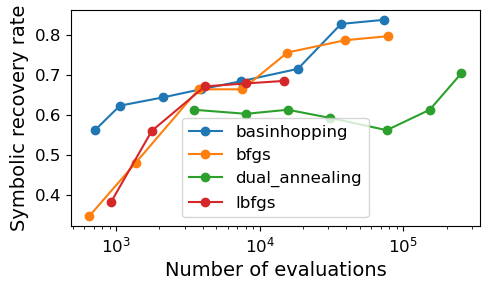

In [48]:
plt.figure(figsize=(5, 3))
optimizers = results_reduced['optimizer'].unique()
for optimizer in optimizers:
    df = results_reduced[results_reduced['optimizer'] == optimizer]
    plt.plot(df['n_evaluations'], df['symbolic_recovery_final'], label=optimizer, marker='o')
plt.xlabel('Number of evaluations', fontsize=14)
plt.ylabel('Symbolic recovery rate', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(path, 'optimizer_comparison_symbolic_recovery_rate_n_evaluations.pdf'))

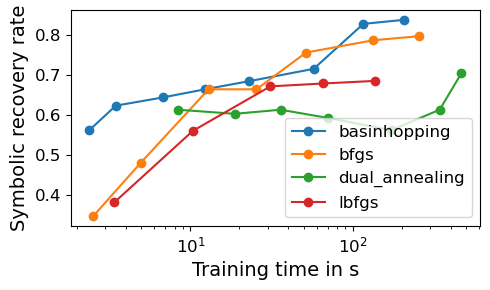

In [53]:
plt.figure(figsize=(5, 3))
optimizers = results_reduced['optimizer'].unique()
for optimizer in optimizers:
    df = results_reduced[results_reduced['optimizer'] == optimizer]
    plt.plot(df['training_time'], df['symbolic_recovery_final'], label=optimizer, marker='o')
plt.xlabel('Training time in s', fontsize=14)
plt.ylabel('Symbolic recovery rate', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(path, 'optimizer_comparison_symbolic_recovery_rate.pdf'))

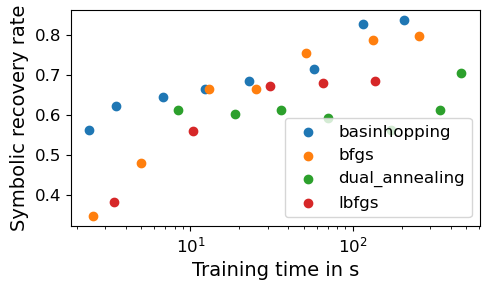

In [55]:
plt.figure(figsize=(5, 3))
optimizers = results_reduced['optimizer'].unique()
for optimizer in optimizers:
    df = results_reduced[results_reduced['optimizer'] == optimizer]
    plt.scatter(df['training_time'], df['symbolic_recovery_final'], label=optimizer, marker='o')
plt.xlabel('Training time in s', fontsize=14)
plt.ylabel('Symbolic recovery rate', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(path, 'optimizer_comparison_symbolic_recovery_rate.pdf'))

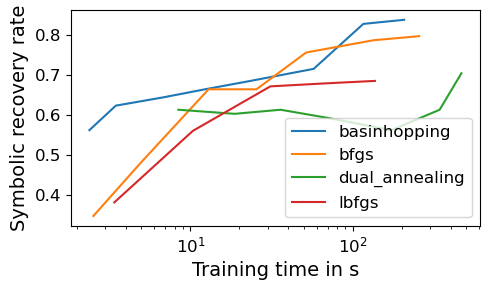

In [51]:
plt.figure(figsize=(5, 3))
optimizers = results_reduced['optimizer'].unique()
for optimizer in optimizers:
    df = results_reduced[results_reduced['optimizer'] == optimizer]
    plt.plot(df['training_time'], df['symbolic_recovery_final'], label=optimizer)
plt.xlabel('Training time in s', fontsize=14)
plt.ylabel('Symbolic recovery rate', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(path, 'optimizer_comparison_symbolic_recovery_rate.pdf'))

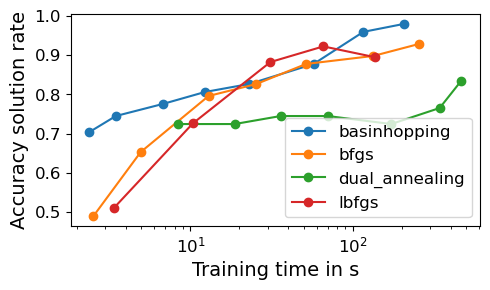

In [54]:
plt.figure(figsize=(5, 3))
optimizers = results_reduced['optimizer'].unique()
for optimizer in optimizers:
    df = results_reduced[results_reduced['optimizer'] == optimizer]
    plt.plot(df['training_time'], df['accuracy_solution_3'], label=optimizer, marker='o')
plt.xlabel('Training time in s', fontsize=14)
plt.ylabel('Accuracy solution rate', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(path, 'optimizer_comparison_accuracy_solution_rate.pdf'))

## ReParFam

In [30]:
results_directory_reparfam = 'results/results_reparfam'

#### Loading

In [32]:
list_results = []
path = os.path.join(results_directory_reparfam)
for directory in os.listdir(path):
    if os.path.isdir(os.path.join(path, directory)):
        results = pd.read_csv(os.path.join(path, directory, 'results.csv'))
        print(f'Directory: {directory}; Length: {len(results)}')
        results = results.rename(columns = {'Unnamed: 0':'Index'})
        for i in range(len(results['Index'])):
            results['Index'][i] = dataset_names_dict[results['dataset'][i]]
        results.index = results['Index']
        results = results.drop('Index', axis=1)
        list_results.append(results)

Directory: 20230915_114646_reparfam; Length: 112
Directory: 20230915_114540_reparfam; Length: 114
Directory: 20230915_114705_reparfam; Length: 81
Directory: 20230915_114928_reparfam_strogatz; Length: 112
Directory: 20230915_114615_reparfam; Length: 107
Directory: 20230915_114520_reparfam; Length: 116
Directory: 20230915_114458_reparfam; Length: 152


/tmp/ipykernel_21339/1178505906.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_21339/1178505906.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset'][i]]
/tmp/ipykernel_21339/1178505906.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Index'][i] = dataset_names_dict[results['dataset']

In [33]:
results = pd.concat(list_results)
results = results.sort_index()
display(results)

,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,function_names,maximal_potence,maximal_n_functions,...,r_squared_test,success,training_time,n_active_coefficients,n_active_coefficients_reduced,relative_l2_distance_test_reduced,r_squared_test_reduced,r_squared_val_reduced,best_formula_reduced,n_evaluations
Index,,,,,,,,,,,,,,,,,,,,,
120,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.997565,False,2542.286,30,30,4.935064e-02,0.997565,0.997697,2.19150026929592*x0*(-0.195287806956173*x1 - 1...,941948
120,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999781,False,2572.401,30,28,1.476060e-02,0.999782,0.999781,-0.494441303650665*x0*(-0.0192883592206532*x1 ...,998371
120,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.999032,False,2586.889,30,30,3.111255e-02,0.999032,0.998974,1.74639800953618*(1.45606757475851*x0 + 0.0073...,987391
120,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.997317,False,2605.758,22,22,5.179914e-02,0.997317,0.997224,(0.0759572136615873*exp((0.0157306724978296*x0...,979626
120,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,1,...,0.996653,False,2721.745,36,35,2.775194e-02,0.999230,0.999232,1.0286441951134*(0.568667994217054*x0 + 0.0125...,989473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,94.917,8,2,3.851351e-08,1.000000,1.000000,-0.0999999999280084*x0,94199
254,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,90.106,8,2,3.783552e-08,1.000000,1.000000,-0.0999999998104944*x0,89644
254,2,3,2,2,"[1, 1, 1]","[1, 1, 1]",1,"['sqrt', 'cos', 'exp']",3,3,...,1.000000,True,313.807,8,2,4.439325e-08,1.000000,1.000000,-0.0999999999325483*x0,309667


In [34]:
results.to_csv(os.path.join(path, 'results_combined.csv'))

#### How to go about the finetuning results?

In [35]:
results['r_squared_test_final'] = results['r_squared_test']
results['n_active_coefficients_final'] = results['n_active_coefficients']
results['estimated_formula_final'] = results['estimated_formula']

In [36]:
# Logic: if the finetuned result is better or it is slightly worse but considerably smaller, we will take it. 
# Otherwise we take the results from the full model.
better_performance = results['r_squared_val'] < results['r_squared_val_reduced']
slightly_worse_performance = (1 - results['r_squared_val']) * 5 > (1 - results['r_squared_val_reduced'])
considerably_less_complexity = results['n_active_coefficients_reduced'] < results['n_active_coefficients'] * 0.75
sum(better_performance), sum(slightly_worse_performance), sum(considerably_less_complexity)

(542, 781, 180)

In [37]:
take_reduced_model = better_performance & (slightly_worse_performance | considerably_less_complexity)
results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
results['n_active_coefficients_final'][take_reduced_model] = results['n_active_coefficients_reduced'][take_reduced_model]
results['estimated_formula_final'][take_reduced_model] = results['best_formula_reduced'][take_reduced_model]

/tmp/ipykernel_21339/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_21339/2960987597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['r_squared_test_final'][take_reduced_model] = results['r_squared_test_reduced'][take_reduced_model]
/tmp/ipykernel_21339/2960987597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

#### Determine the symbolic solution rate

## Feynmann data

In [57]:
feynmann_indices = [i for i in range(120, 239)]
results_feynman = results.truncate(120, 238)

#### Which experiments are still missing?

In [58]:
missing_experiments = []
for i in feynmann_indices:
    if sum(results_feynman.index == i) < 1:
        missing_experiments.append(i)

In [59]:
missing_experiments

[230, 231, 232, 233, 234, 235, 236, 237, 238]

In [60]:
double_experiments = []
for i in feynmann_indices:
    if sum(results_feynman.index == i) > 1:
        double_experiments.append(i)
double_experiments

[]

In [17]:
results_feynmann = results_feynmann.groupby(['Index', 'maxiter1'], as_index=True).last()

In [9]:
missing_experiments = []
for i in feynmann_indices:
    if sum(results_feynmann[results_feynmann['maxiter1']==100].index == i) < 1:
        missing_experiments.append(i)
missing_experiments

[123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 157,
 158,
 159,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 229,
 230,
 231,
 236]

In [10]:
double_experiments = []
for i in feynmann_indices:
    if sum(results_feynmann.index == i) > 2:
        double_experiments.append(i)
double_experiments

[]

#### How successful?

In [11]:
results_feynmann.groupby('maxiter1').mean()[['success', 'r_squared_test', 'n_active_coefficients', 'training_time']]

,success,r_squared_test,n_active_coefficients,training_time
maxiter1,,,,
100,0.6375,0.999959,90.25,18759.0417


In [12]:
(results_feynmann['r_squared_test'] > 0.999).mean()

0.9875

In [13]:
results_feynmann[results_feynmann['r_squared_test'] < 0.999]['target_formula']

Index
224    Ef*cos(theta)*(-r+d**3/r**2*(alpha-1)/(alpha+2))
Name: target_formula, dtype: object

In [18]:
results_feynmann[(results_feynmann['training_time'] > 8 * 3600 / 6) & (results_feynmann['success'])]['best_formula_reduced']

Index
136                0.333333333333333*x0*x1**2*x2/(x3*x4)
163    0.08*x1*cos((0.366*x0*x2 + 0.568*x1*x2 + 0.609...
172    0.0232748147146223*x0*sqrt(Abs(x1**2))/(-0.169...
Name: best_formula_reduced, dtype: object

In [39]:
directory

'20230805_121850_philipp_cluster_specific_hp'

## Analysis of the formulas

190 geht allgemein nicht, overleaf abchecken

194, 234 haben einen Term hoch 2/3

In [55]:
list_polynomials = [121, 147, 148, 151, 158, 166, 169, 170, 174, 176, 177, 178, 186, 198, 202, 208]
list_rationals = [122, 125, 126, 128, 132, 135, 136, 137, 138, 139, 140, 145, 149, 150, 152, 153, 154, 157, 159, 160,
                 161, 162, 167, 172, 173, 175, 182, 185, 187, 189, 191, 195, 196, 199, 201, 203, 204, 207, 209,
                 218, 227, 228, 229]
list_impossible = [128, 134, 140, 146, 155, 156, 157, 164, 165, 188, 190, 192, 193, 194, 195, 200, 205, 206, 210, 
                   213, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 235, 
                   236, 238]

In [56]:
list_failed_formulas = []

In [57]:
len(list_polynomials) / (238 - 119), len(list_rationals) / (238 - 119), len(list_impossible) / (238 - 119)

(0.13445378151260504, 0.36134453781512604, 0.33613445378151263)